# Stickiness estimation for DLA

#### N : Number of particles, k : stickiness factor

### We attempt to find a characteristic that can be mapped to a given (n, k). We explore two such functions over here, the surface area of the image and the number of nieghbours for all the particles points in the image. 

### We ran 15 simulations for n in range(100, 20001, 100) and k in linspace(1e-3, 5e-2, 40). The simualations were used to calculate average values surface area for a particular (n, k) pair. 

### Data from the simulaions can be found in the `logFiles` dir

In [1]:
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10, 6)

from collections import defaultdict
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
kVals = ["0.038394755", "0.03710528", "0.035815805", "0.03452633", "0.033236855", "0.03194738", \
         "0.030657905", "0.02936843", "0.028078955", "0.02678948", "0.02421053", "0.025500005", \
         "0.022921055", "0.020342115", "0.02163158", "0.017763175", "0.01905265", "0.0164737",  \
         "0.01389475", "0.015184225", "0.04742108", "0.048710555", "0.05", "0.04226318",        \
         "0.043552655", "0.04484213", "0.046131605", "0.03968423", "0.040973705", "0.001",      \
         "0.002289475", "0.00357895", "0.004868425", "0.0061579", "0.007447375", "0.00873685",  \
         "0.0113158", "0.010026325", "0.012605275"]

kVals = sorted(kVals, key = lambda x: float(x))
fileNames = map(lambda x : 'logFiles/dla_' + x + '.log', kVals) + \
            map(lambda x : 'logFiles2/dla_' + x + '.log', kVals)

In [3]:
# Aggregating results from logfiles

saTable = defaultdict(lambda : defaultdict(list)) # (n, k) : [sa, ...]
for fi in fileNames:
    with open(fi, 'r') as fp:
        data = fp.readlines()
        data = map(lambda x : eval(x.strip('\n')), data)
        
    for point in data:
        saTable[point['n']][point['k']].append(point['sa'])
        
for n in saTable.keys():
    if n > 20000:
        del saTable[n]
        continue
        
    for k, val in saTable[n].iteritems():
        saTable[n][k] = np.mean(val)

### Plotting surface area vs n  for given k, clearly increasing

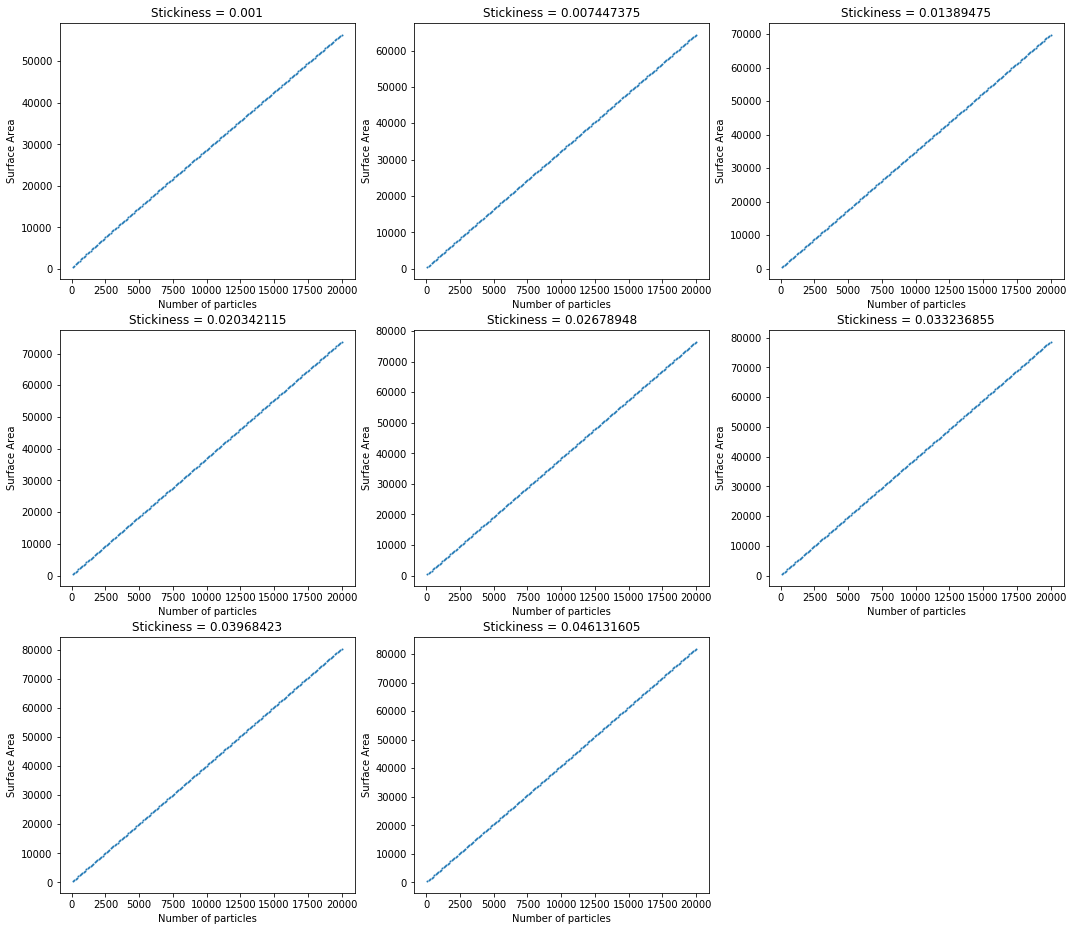

In [4]:
pylab.rcParams['figure.figsize'] = (18, 16)

count = 1
for k in kVals[::5]:

    x = range(100, 20001, 100)
    y = [saTable[n][float(k)] for n in x]
    
    fig = plt.subplot(3, 3, count)
    plt.title("Stickiness = " + str(k))
    plt.xlabel("Number of particles")
    plt.ylabel("Surface Area")
    fig.scatter(x, y, s = 1)
    count += 1

### Plotting  SA vs k for a given n

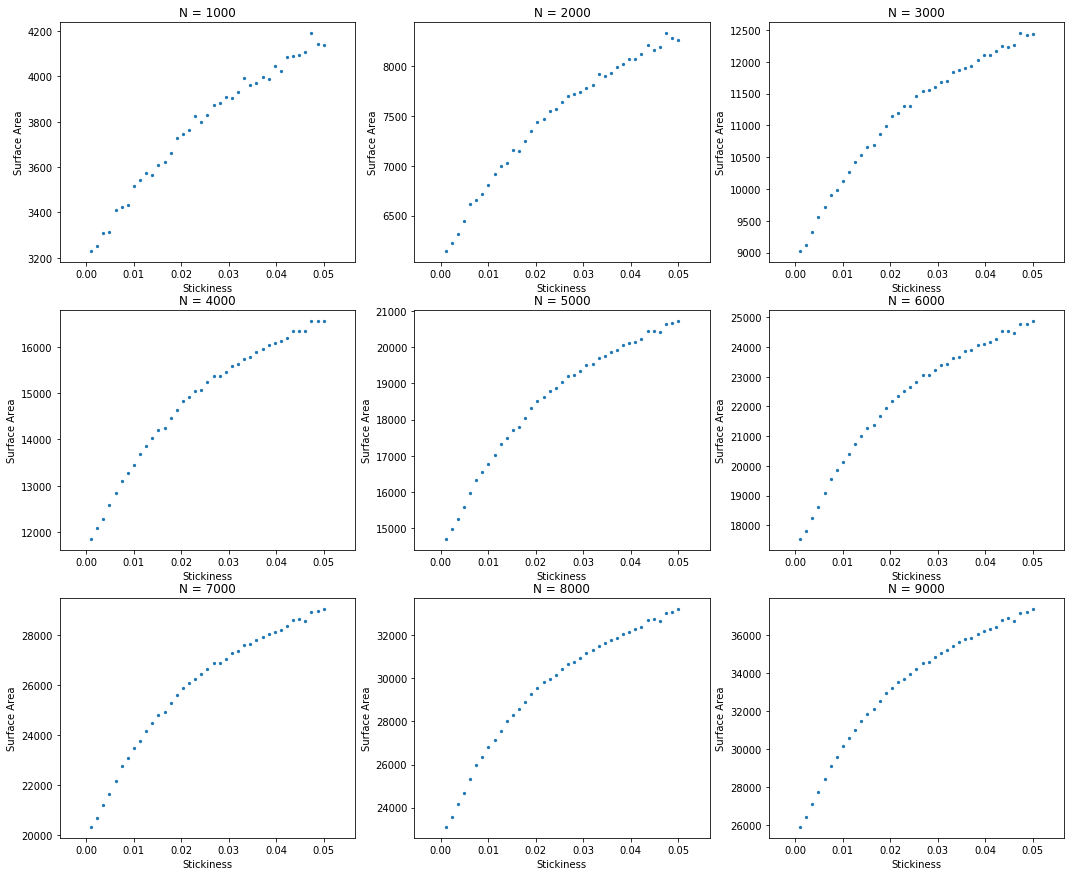

In [5]:
pylab.rcParams['figure.figsize'] = (18, 15)

count = 1
for n in range(1000, 9001, 1000):
    
    x, y = [], []
    for i, val in enumerate(kVals):
        x.append(float(val))
        y.append(np.mean(saTable[n][float(val)]))
        
    fig = plt.subplot(3, 3, count)
    plt.title("N = " + str(n))
    plt.xlabel("Stickiness")
    plt.ylabel("Surface Area")
    fig.scatter(x, y, s = 5)
    count += 1

#### Looks like a log distribution, but unbounded. Let's plot Average Surface area vs k

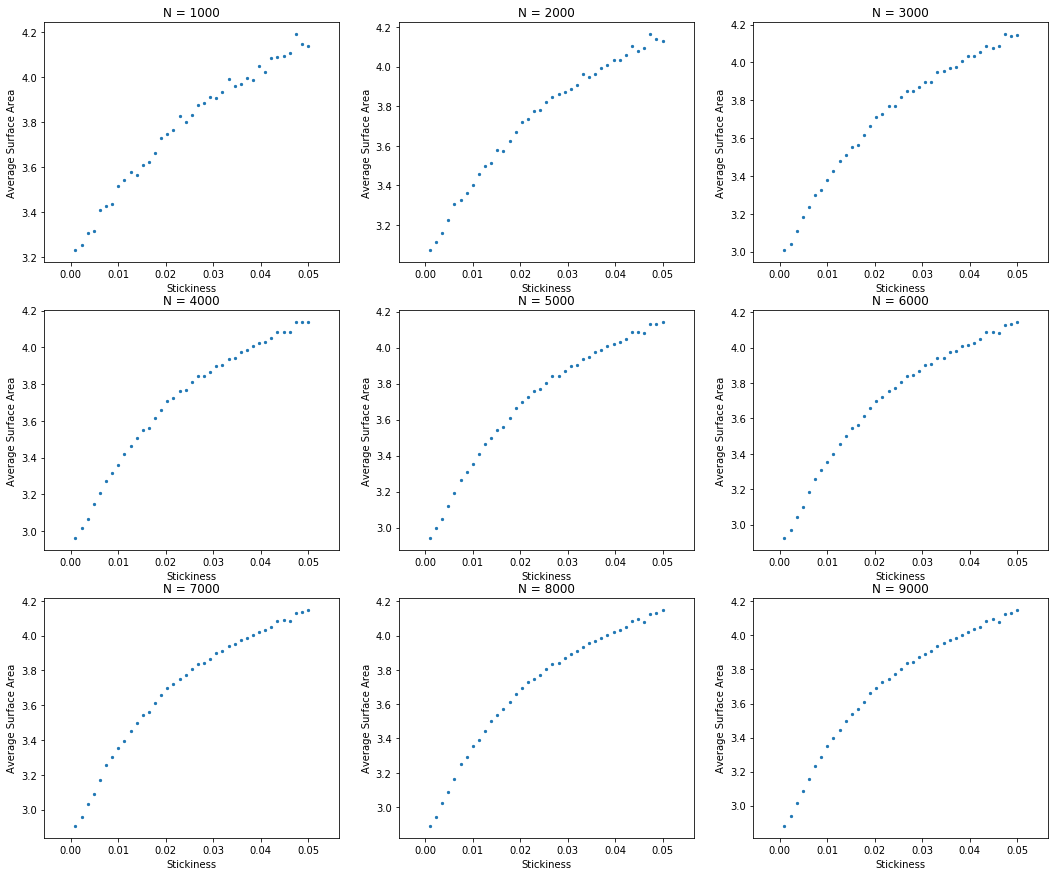

In [6]:
pylab.rcParams['figure.figsize'] = (18, 15)

count = 1
for n in range(1000, 9001, 1000):
    
    x, y = [], []
    for i, val in enumerate(kVals):
        x.append(float(val))
        y.append(np.mean(saTable[n][float(val)]))
        

    fig = plt.subplot(3, 3, count)
    plt.title("N = " + str(n))
    plt.xlabel("Stickiness")
    plt.ylabel("Average Surface Area")
    fig.scatter(x, np.array(y) / n, s = 5)
    count += 1


#### We can see that taking the average of the surface area somewhat bounds the range, much better for fitting a curve. Plotting Average Surface Area vs log(stickiness)

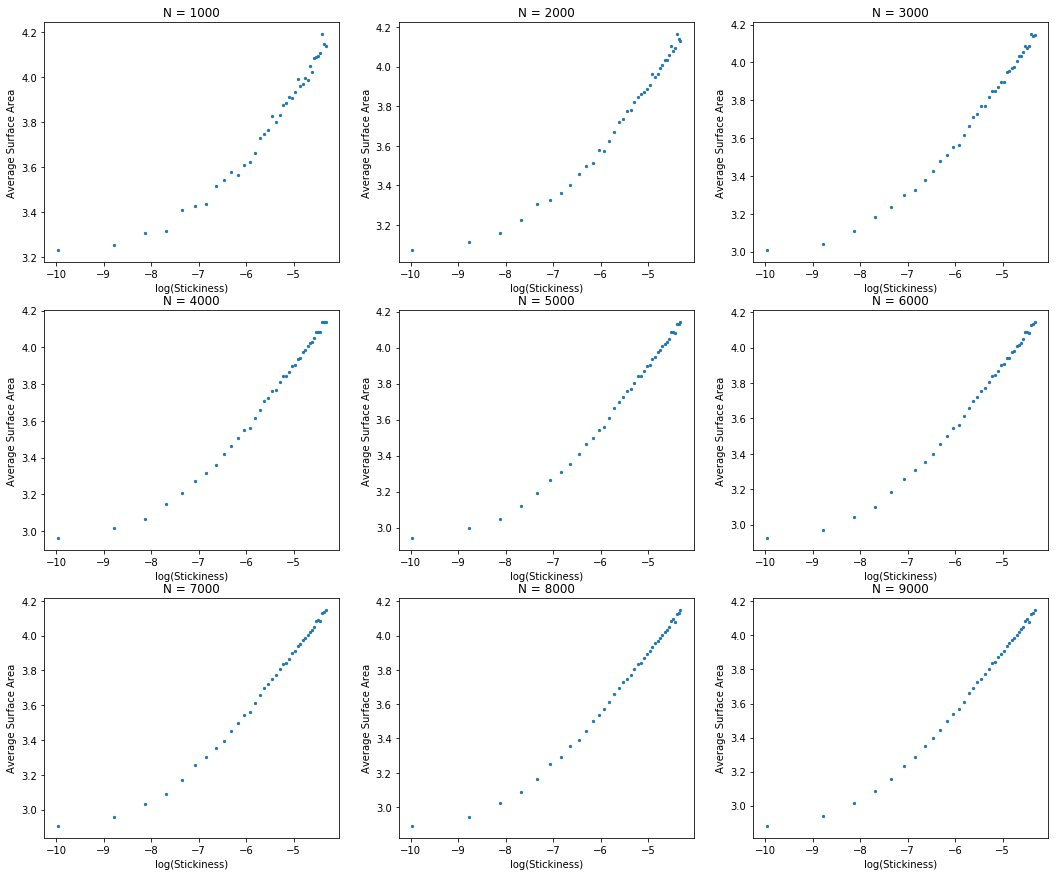

In [7]:
pylab.rcParams['figure.figsize'] = (18, 15)

count = 1
for n in range(1000, 9001, 1000):
    
    x, y = [], []
    for i, val in enumerate(kVals):
        x.append(float(val))
        y.append(np.mean(saTable[n][float(val)]))
        

    fig = plt.subplot(3, 3, count)
    plt.title("N = " + str(n))
    plt.xlabel("log(Stickiness)")
    plt.ylabel("Average Surface Area")
    fig.scatter(np.log2(x), np.array(y) / n, s = 5)
    count += 1

#### Looks like as stickiness increases (in our bound [1e-3, 2e-5]), log(stickiness) vs average surface area fits a straight line. Smaller values of k don't look good though, maybe a second degree poly?

For evaluation, can partition data in two ways
    - Split across different N (keep all K for a single N together while training)
    - Split across (N, K) 
    
Makes sense to split across different N instead of (N, K) since very high probability of encountering an unknown N at test time. Hence, N should always be an unseen paramter

#### Insted of cross validaiton, sequential partitioning for test makes more sense. At test time, n can only increase.

In [8]:
# Change SA to Average SA in data 
for n in saTable.keys():
    for k, val in saTable[n].iteritems():
        saTable[n][k] = float(val) / n

In [9]:
trainData = [sorted(saTable[n].items(), key = lambda x : x[0]) for n in range(100, 15001, 100)]
testData = [sorted(saTable[n].items(), key = lambda x : x[0]) for n in range(15100, 20001, 100)]

In [10]:
# x -> Average Surface Area
# y -> log(Stickiness) 

trainX = np.array(reduce(lambda a, b : a + b, map(lambda x : map(lambda y : y[1], x), trainData)))
trainy = np.array(reduce(lambda a, b : a + b, map(lambda x : map(lambda y : np.log2(y[0]), x), trainData)))

testX = np.array(reduce(lambda a, b : a + b, map(lambda x : map(lambda y : y[1], x), testData)))
testy = np.array(reduce(lambda a, b : a + b, map(lambda x : map(lambda y : np.log2(y[0]), x), testData)))

allX = np.concatenate((trainX, testX), axis = 0)
ally = np.concatenate((trainy, testy), axis = 0)

In [11]:
trainX.shape, trainy.shape, testX.shape, testy.shape, allX.shape, ally.shape

((5850,), (5850,), (1950,), (1950,), (7800,), (7800,))

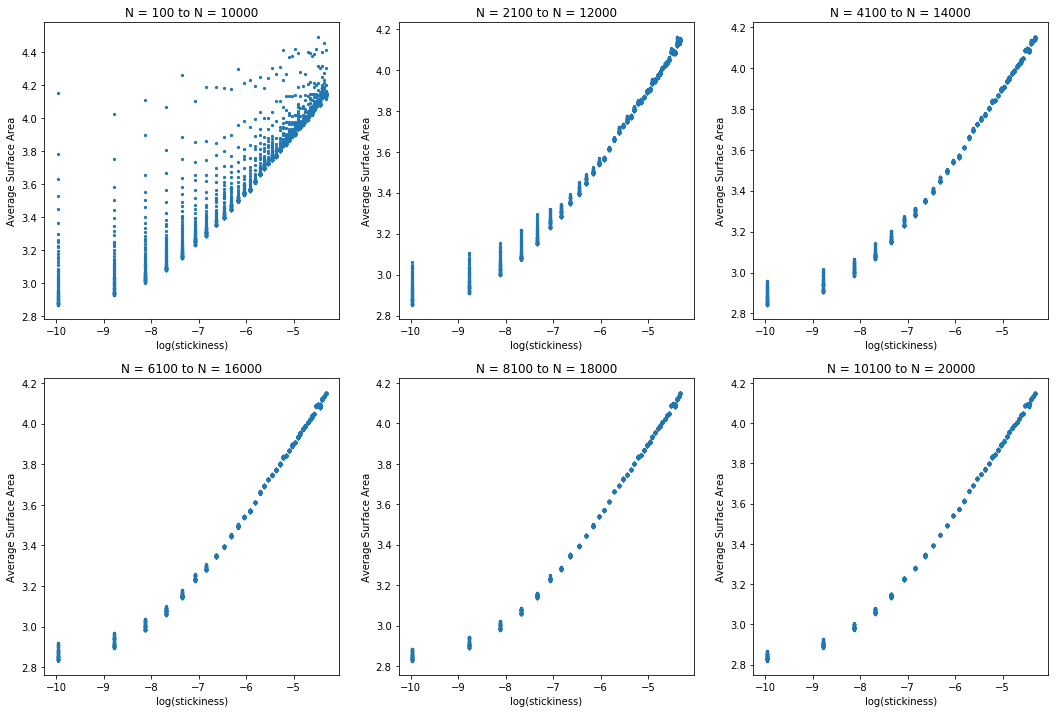

In [12]:
pylab.rcParams['figure.figsize'] = (18, 12)

for n in range(1, 7):
    
    fig = plt.subplot(2, 3, n)
    plt.title("N = " + str(100 + (n - 1) * 20 * 100) + " to N = " + str((n - 1) * 20 * 100 + 100 * 100))
    plt.xlabel('log(stickiness)')
    plt.ylabel('Average Surface Area')
    
    toPlotX = allX[(n - 1) * 20 * 39 : (n - 1) * 20 * 39 + 39 * 100]
    toPloty = ally[(n - 1) * 20 * 39 : (n - 1) * 20 * 39 + 39 * 100]

    fig.scatter(y = toPlotX, x = toPloty, s = 5)
    

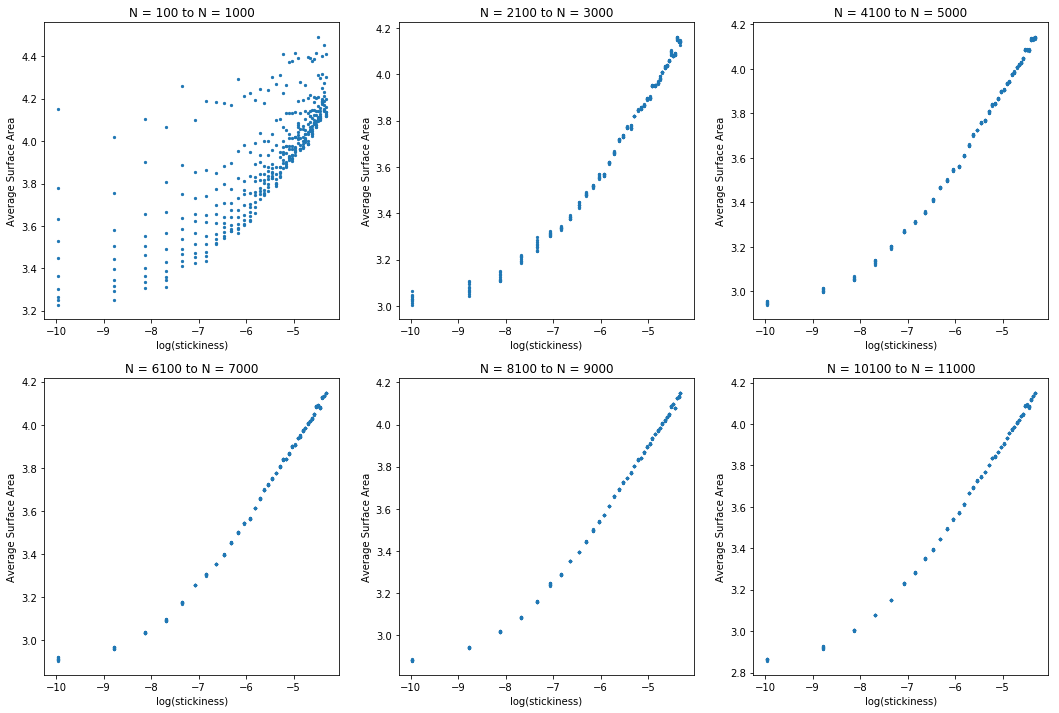

In [13]:
pylab.rcParams['figure.figsize'] = (18, 12)

for n in range(1, 7):
    
    fig = plt.subplot(2, 3, n)
    plt.title("N = " + str(100 + (n - 1) * 20 * 100) + " to N = " + str((n - 1) * 20 * 100 + 100 * 10))
    plt.xlabel('log(stickiness)')
    plt.ylabel('Average Surface Area')
    
    toPlotX = allX[(n - 1) * 20 * 39 : (n - 1) * 20 * 39 + 39 * 10]
    toPloty = ally[(n - 1) * 20 * 39 : (n - 1) * 20 * 39 + 39 * 10]

    fig.scatter(y = toPlotX, x = toPloty, s = 5)
    

### We notice that as the value of n increases, average surface area tends to scatter less. Hence estimation will be more accurate for larger n. Also, makes sense to do something like locally weighted regression

## Fitting polynomaials to entire data. Train n : [100, 15000] Test n : [15100, 20000]

In [14]:
coeffs = np.polyfit(trainX, trainy, 1)
f1 = np.poly1d(coeffs)
coeffs = np.polyfit(trainX, trainy, 2)
f2 = np.poly1d(coeffs)
coeffs = np.polyfit(trainX, trainy, 3)
f3 = np.poly1d(coeffs)

Poly order 1 

Train Error in logk 0.408056710612
Train Error in k 0.00541435469473
Test Error in logk 0.275759509862
Test Error in k 0.0021457641279 

Poly order 2 

Train Error in logk 0.349949250487
Train Error in k 0.00348367147528
Test Error in logk 0.216768803713
Test Error in k 0.0019416587249 

Poly order 3 

Train Error in logk 0.346718728786
Train Error in k 0.00378420862321
Test Error in logk 0.204355086704
Test Error in k 0.00166000318459 



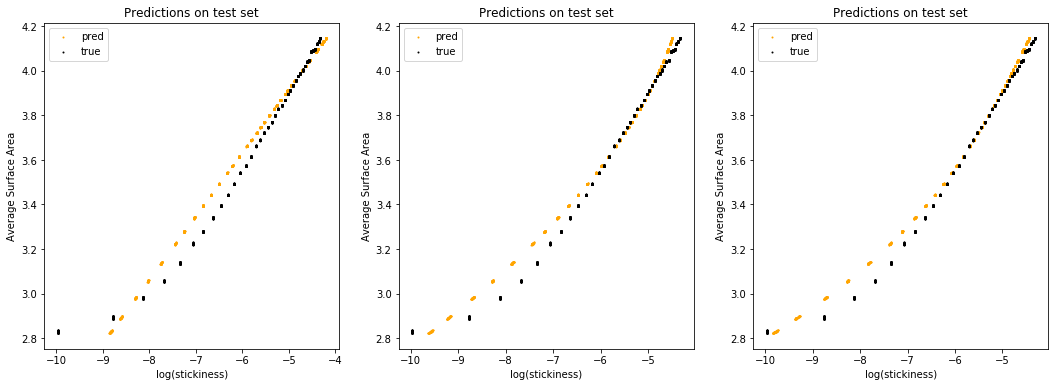

In [15]:
pylab.rcParams['figure.figsize'] = (18, 6)


print 'Poly order 1', '\n'
pred = f1(trainX)
error = (pred - trainy) ** 2
print 'Train Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** trainy) ** 2
print 'Train Error in k', np.mean(error) ** 0.5

pred = f1(testX)
error = (pred - testy) ** 2
print 'Test Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** testy) ** 2
print 'Test Error in k', np.mean(error) ** 0.5, '\n'

fig = plt.subplot(1, 3, 1)
plt.scatter(y = testX, x = pred, s = 1, c = 'orange', label = 'pred')
plt.scatter(y = testX, x = testy, s = 1, c = 'black', label = 'true')
plt.title('Predictions on test set')
plt.xlabel('log(stickiness)')
plt.ylabel('Average Surface Area')
plt.legend()

# Order 2 poly
print 'Poly order 2', '\n'
pred = f2(trainX)
error = (pred - trainy) ** 2
print 'Train Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** trainy) ** 2
print 'Train Error in k', np.mean(error) ** 0.5

pred = f2(testX)
error = (pred - testy) ** 2
print 'Test Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** testy) ** 2
print 'Test Error in k', np.mean(error) ** 0.5, '\n'

fig = plt.subplot(1, 3, 2)
plt.scatter(y = testX, x = pred, s = 1, c = 'orange', label = 'pred')
plt.scatter(y = testX, x = testy, s = 1, c = 'black', label = 'true')
plt.title('Predictions on test set')
plt.xlabel('log(stickiness)')
plt.ylabel('Average Surface Area')
plt.legend()

# Order 3 poly
print 'Poly order 3', '\n'
pred = f3(trainX)
error = (pred - trainy) ** 2
print 'Train Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** trainy) ** 2
print 'Train Error in k', np.mean(error) ** 0.5

pred = f3(testX)
error = (pred - testy) ** 2
print 'Test Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** testy) ** 2
print 'Test Error in k', np.mean(error) ** 0.5, '\n'

fig = plt.subplot(1, 3, 3)
plt.scatter(y = testX, x = pred, s = 1, c = 'orange', label = 'pred')
plt.scatter(y = testX, x = testy, s = 1, c = 'black', label = 'true')
plt.title('Predictions on test set')
plt.xlabel('log(stickiness)')
plt.ylabel('Average Surface Area')
plt.legend()


- Seems like a fit, error in k is low (we're bounded in [1e-3, 5e-2]). Error % = 0.00166000318459 / (5e-2 - 1e-3) = 3.38 %
- Notice: Train error is high. Expected because we saw high scattering for small k. Let's try to see if using only data closer to our given n can give a better fit

## Fitting polynomaials to partial data. Train n : [10100, 15000] Test n : [15100, 20000]

In [16]:
coeffs = np.polyfit(trainX[3900:], trainy[3900:], 1)
f1 = np.poly1d(coeffs)
coeffs = np.polyfit(trainX[3900:], trainy[3900:], 2)
f2 = np.poly1d(coeffs)
coeffs = np.polyfit(trainX[3900:], trainy[3900:], 3)
f3 = np.poly1d(coeffs)

Poly order 1 

Train Error in logk 0.267226607008
Train Error in k 0.00258379209622
Test Error in logk 0.258970637908
Test Error in k 0.00257029585248 

Poly order 2 

Train Error in logk 0.171016657275
Train Error in k 0.00162205823939
Test Error in logk 0.16923848371
Test Error in k 0.00162872003593 

Poly order 3 

Train Error in logk 0.109334593433
Train Error in k 0.00113765189647
Test Error in logk 0.113925728284
Test Error in k 0.00106134661616 



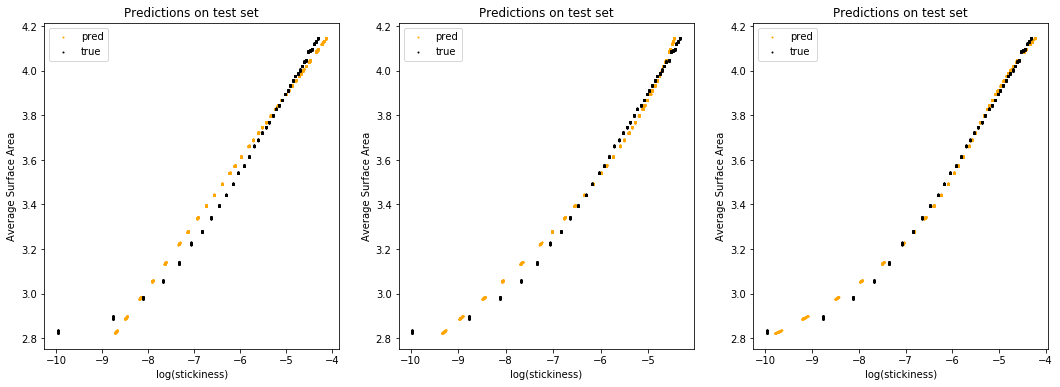

In [17]:
pylab.rcParams['figure.figsize'] = (18, 6)


print 'Poly order 1', '\n'
pred = f1(trainX[3900:])
error = (pred - trainy[3900:]) ** 2
print 'Train Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** trainy[3900:]) ** 2
print 'Train Error in k', np.mean(error) ** 0.5

pred = f1(testX)
error = (pred - testy) ** 2
print 'Test Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** testy) ** 2
print 'Test Error in k', np.mean(error) ** 0.5, '\n'

fig = plt.subplot(1, 3, 1)
plt.scatter(y = testX, x = pred, s = 1, c = 'orange', label = 'pred')
plt.scatter(y = testX, x = testy, s = 1, c = 'black', label = 'true')
plt.title('Predictions on test set')
plt.xlabel('log(stickiness)')
plt.ylabel('Average Surface Area')
plt.legend()


# Order 2 poly
print 'Poly order 2', '\n'
pred = f2(trainX[3900:])
error = (pred - trainy[3900:]) ** 2
print 'Train Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** trainy[3900:]) ** 2
print 'Train Error in k', np.mean(error) ** 0.5

pred = f2(testX)
error = (pred - testy) ** 2
print 'Test Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** testy) ** 2
print 'Test Error in k', np.mean(error) ** 0.5, '\n'

fig = plt.subplot(1, 3, 2)
plt.scatter(y = testX, x = pred, s = 1, c = 'orange', label = 'pred')
plt.scatter(y = testX, x = testy, s = 1, c = 'black', label = 'true')
plt.title('Predictions on test set')
plt.xlabel('log(stickiness)')
plt.ylabel('Average Surface Area')
plt.legend()

# Order 3 poly
print 'Poly order 3', '\n'
pred = f3(trainX[3900:])
error = (pred - trainy[3900:]) ** 2
print 'Train Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** trainy[3900:]) ** 2
print 'Train Error in k', np.mean(error) ** 0.5

pred = f3(testX)
error = (pred - testy) ** 2
print 'Test Error in logk', np.mean(error) ** 0.5
error = (2 ** pred - 2 ** testy) ** 2
print 'Test Error in k', np.mean(error) ** 0.5, '\n'

fig = plt.subplot(1, 3, 3)
plt.scatter(y = testX, x = pred, s = 1, c = 'orange', label = 'pred')
plt.scatter(y = testX, x = testy, s = 1, c = 'black', label = 'true')
plt.title('Predictions on test set')
plt.xlabel('log(stickiness)')
plt.ylabel('Average Surface Area')
plt.legend()

- Really interesting to notice that error on the test has decreased. E % = .00106134661616 / (5e-2 - 1e-3) = 2.16 %. Our estimate improved when we discarded data for n much smaller than the target n. 
- Another important thing to note, the train error also went down in this case.
#### The above two points strong suggest that we should try a locally weighted regression.

# Locally weighted regression (windowed)

#### Idea is to use only data from a fixed range of `n` smaller than the given `n` . Since training time in neglegible, we can train the model in real time depending on the give `n` in the DLA image. 

In [18]:
errors = []

for n in range(2000, 20001, 100):
    
    begInd = (n - 1) / 100 * 39
    endInd = (n) / 100 * 39

    testX = allX[begInd : endInd]
    testy = ally[begInd : endInd]

    # Take a window of 20 n's (2000 particle window)
    
    if begInd - 39 * 10 < 0:
        start = 0
    else:
        start = begInd - 39 * 10
    
    trainX = np.concatenate((allX[start : begInd], allX[endInd: endInd + 39 * 10]))
    trainy = np.concatenate((ally[start : begInd], ally[endInd: endInd + 39 * 10]))

    
    coeffs = np.polyfit(trainX, trainy, 1)
    f1 = np.poly1d(coeffs)
    pred = f1(testX)
    error = (2 ** pred - 2 **testy) ** 2
    error1 = np.mean(error) ** 0.5
    
    coeffs = np.polyfit(trainX, trainy, 2)
    f2 = np.poly1d(coeffs)
    pred = f2(testX)
    error = (2 ** pred - 2 **testy) ** 2
    error2 = np.mean(error) ** 0.5
    
    coeffs = np.polyfit(trainX, trainy, 3)
    f3 = np.poly1d(coeffs)
    pred = f3(testX)
    error = (2 ** pred - 2 **testy) ** 2
    error3 = np.mean(error) ** 0.5
    
    errors.append([error1, error2, error3])
errors = np.array(errors)

In [19]:
errors[:, 0].mean(), errors[:, 1].mean(), errors[:, 2].mean(), 

(0.0027735942772775836, 0.001709251689459496, 0.0011891077040634065)

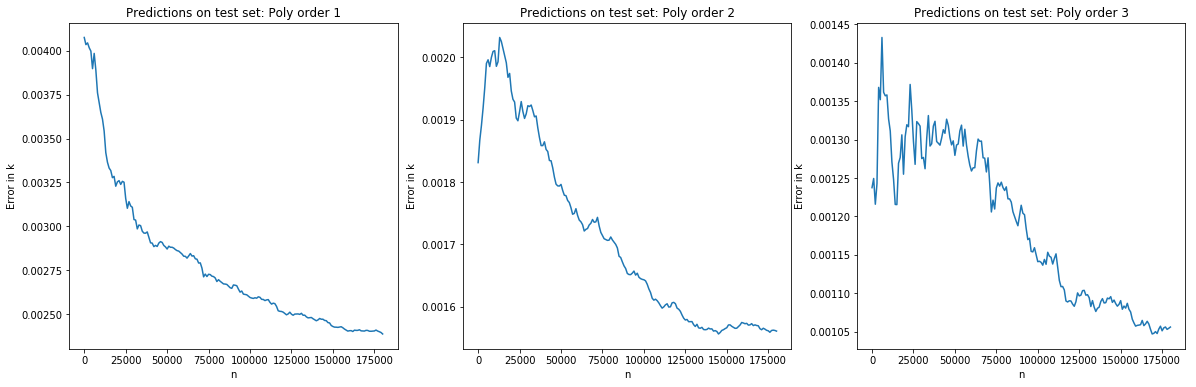

In [20]:
pylab.rcParams['figure.figsize'] = (20, 6)

fig = plt.subplot(1, 3, 1)
plt.plot(np.array(range(errors.shape[0])) * 1000, errors[:, 0])
plt.title('Predictions on test set: Poly order 1')
plt.xlabel('n')
plt.ylabel('Error in k')

fig = plt.subplot(1, 3, 2)
plt.plot(np.array(range(errors.shape[0])) * 1000, errors[:, 1])
plt.title('Predictions on test set: Poly order 2')
plt.xlabel('n')
plt.ylabel('Error in k')

fig = plt.subplot(1, 3, 3)
plt.plot(np.array(range(errors.shape[0])) * 1000, errors[:, 2])
plt.title('Predictions on test set: Poly order 3')
plt.xlabel('n')
plt.ylabel('Error in k')

For the 3 degree poly, the worst error percentage (0.0019) is better than the average train error in the previous fit. Hence a local fit is definitely a better one.

### So our strategy to predict stickiness is the following. For a given `n`, we take a window of n from the data and fit a 3rd degree polynomial. We use this polynomial to predict the k for the given `n`.